##### Import & Seed:

In [3]:
# Libraries:
import pysindy as ps
import numpy as np
import matplotlib.pyplot as plt
import dill
import sys
import os

from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from scipy.integrate import odeint
from scipy.linalg import hankel
from pyDOE import lhs
from scipy.io import savemat
from sklearn.utils.extmath import randomized_svd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
#from pysindy.optimizers import SR3

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..'))) # include parent directory in the path
from data import SINDy_data
from data import data
from data import equations

# Seed:
np.random.seed(999)

### STD:

In [19]:
# Select ODE & settings:
ode_name = 'LogisticODE'
ode_param=None
freq = 10 # 5
dt = 1 / freq
n_sample = 50 
noise_ratio = 0.01
dim_x = 1
dim_k = 0
ode = equations.get_ode(ode_name, ode_param)
time_vector = np.arange(0, ode.T + dt, dt)

In [20]:
# generate data:
X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_ratio, dim_x, dim_k, T=ode.T)
print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
print(feature_names)

# save data:
file_path = 'saved/data/logistic_data.pkl'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, 'wb') as f:
    dill.dump((X_list, dX_list, param_list, feature_names), f)

(50, 100, 1) (50, 100, 1) (0,)
['X0']


In [21]:
# uploda data:
file_path = 'saved/data/logistic_data.pkl'
with open(file_path, 'rb') as f:
    X_list, dX_list, param_list, feature_names = dill.load(f)

In [9]:
# SINDy models:
model_0 = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=True), optimizer=ps.STLSQ(threshold=0.1))
model_0.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)
model_0.print()
A_0 = model_0.coefficients()
n_features_0 = A_0.shape[1]

model_1 = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=True), optimizer=ps.STLSQ(threshold=0.5))
model_1.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)
model_1.print()

model_2 = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=True), optimizer=Lasso(alpha=0.001))
model_2.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)
model_2.print()

(X0)' = 0.746 X0 + -1.057 X0^2 + 0.317 X0^3
(X0)' = 0.621 X0 + -0.635 X0^2
(X0)' = 0.307 X0 + -0.369 X0^3 + 0.071


In [22]:
# best model:
best_threshold = 0.01
model_b = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=True), optimizer=ps.STLSQ(threshold=best_threshold))
model_b.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)
model_b.print()

(X0)' = 0.746 X0 + -1.057 X0^2 + 0.317 X0^3


Best Model RMSE:  0.025189476551752223


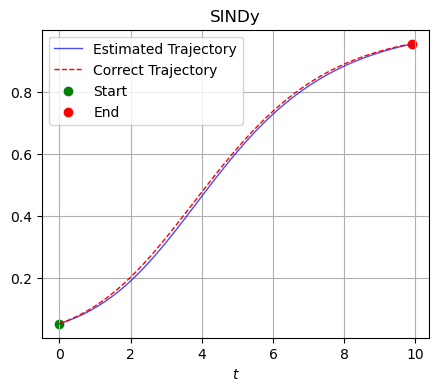

In [24]:
# evaluation:
n_sample = 25
rmse_b, _ = SINDy_data.evaluate_RMSE(model_b, ode, freq, n_sample, [0.1], [0.], dim_k)
print('Best Model RMSE: ', rmse_b)

n_sample = 1
title = 'SINDy'
SINDy_data.evaluate_traj(model_b, ode, freq, n_sample, [0.05], [0.05], dim_x, dim_k, title=title, T_aux=10)

### Parametrization on $a$

In [13]:
# Select ODE & settings:
ode_name = 'LogisticODE_a'
ode_param=None
freq = 10 # 5
dt = 1 / freq
n_sample = 50 
noise_ratio = 0.01
dim_x = 1
dim_k = 1
ode = equations.get_ode(ode_name, ode_param)
time_vector = np.arange(0, ode.T + dt, dt)

In [14]:
# generate data:
X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_ratio, dim_x, dim_k, T=ode.T)
print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
print(feature_names)

# save data:
file_path = 'saved/data/logistic_data_a.pkl'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, 'wb') as f:
    dill.dump((X_list, dX_list, param_list, feature_names), f)

(50, 100, 1) (50, 100, 1) (50, 100)
['X0', 'X1']


In [15]:
# uploda data:
file_path = 'saved/data/logistic_data_a.pkl'
with open(file_path, 'rb') as f:
    X_list, dX_list, param_list, feature_names = dill.load(f)

In [16]:
# best model:
best_threshold = 0.01
model_b = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=True), optimizer=ps.STLSQ(threshold=best_threshold))
model_b.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
model_b.print()

(X0)' = -0.019 1 + 0.156 X0 + 0.036 X1 + -0.353 X0^2 + 0.504 X0 X1 + -0.009 X1^2 + 0.264 X0^3 + -0.601 X0^2 X1 + 0.029 X0 X1^2


Best Model RMSE:  0.02679578708514889


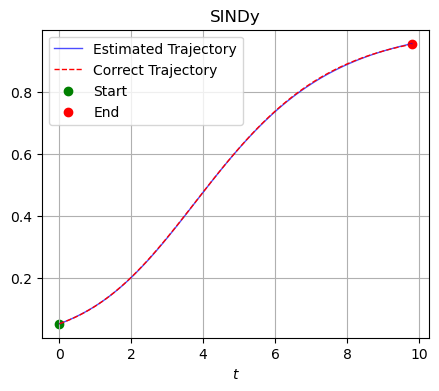

In [18]:
# evaluation:
n_sample = 25
rmse_b, _ = SINDy_data.evaluate_RMSE(model_b, ode, freq, n_sample, [0.1, 1.5], [0., 0.5], dim_k)
print('Best Model RMSE: ', rmse_b)
n_sample = 1
title = 'SINDy'
SINDy_data.evaluate_traj(model_b, ode, freq, n_sample, [0.05, 1.0], [0.05, 1.0], dim_x, dim_k, title=title, T_aux=10)

### Parametrization on $k$

In [25]:
# Select ODE & settings:
ode_name = 'LogisticODE_k'
ode_param=None
freq = 10 # 5
dt = 1 / freq
n_sample = 50 
noise_ratio = 0.01
dim_x = 1
dim_k = 1
ode = equations.get_ode(ode_name, ode_param)
time_vector = np.arange(0, ode.T + dt, dt)

In [26]:
# generate data:
X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_ratio, dim_x, dim_k)
print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
print(feature_names)

# save data:
file_path = 'saved/data/logistic_data_k.pkl'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, 'wb') as f:
    dill.dump((X_list, dX_list, param_list, feature_names), f)

(50, 100, 1) (50, 100, 1) (50, 100)
['X0', 'X1']


In [27]:
# uploda data:
file_path = 'saved/data/logistic_data_k.pkl'
with open(file_path, 'rb') as f:
    X_list, dX_list, param_list, feature_names = dill.load(f)

In [31]:
# SINDy models:
model_0 = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=True), optimizer=ps.STLSQ(threshold=0.1))
model_0.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
model_0.print()
A_0 = model_0.coefficients()
n_features_0 = A_0.shape[1]

model_1 = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=True), optimizer=ps.STLSQ(threshold=0.5))
model_1.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
model_1.print()

model_2 = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=True), optimizer=Lasso(alpha=0.001))
model_2.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
model_2.print()

(X0)' = 0.239 X0 + -0.255 X0^2 + 0.729 X0 X1 + -0.714 X0^2 X1
(X0)' = 0.957 X0 X1 + -0.956 X0^2 X1
(X0)' = 0.517 X0 + 0.095 X1 + 0.008 X0 X1 + -0.583 X0^3 + -0.004


Threshold:  0.001 , RMSE:  1.988558622836163
Threshold:  0.01 , RMSE:  1.988558622836163
Threshold:  0.05 , RMSE:  0.05295823755972151
Threshold:  0.1 , RMSE:  0.05295823755972151
Threshold:  0.2 , RMSE:  0.13521272016215966
Threshold:  0.4 , RMSE:  0.13521272016215966
Threshold:  0.6 , RMSE:  0.13521272016215966
Threshold:  0.8 , RMSE:  0.5309632366129534


/Users/grgromano/miniconda3/envs/smart_SINDy/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (0.8) and eliminated all coefficients
  warnings.warn(


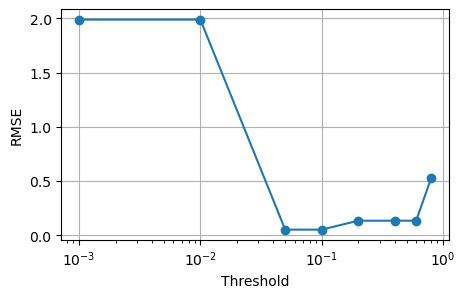

In [ ]:
# model selection:
thresholds = np.array([ 0.001, 0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8])
rmse_values = np.zeros(len(thresholds))
for i in range(len(thresholds)):
    model = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=True), optimizer=ps.STLSQ(threshold=thresholds[i]))
    model.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
    rmse, _ = SINDy_data.evaluate_RMSE(model, ode, freq, 10, [0.1, 1.5], [0., 0.2], dim_k)
    rmse_values[i] = rmse
    print('Threshold: ', thresholds[i], ', RMSE: ', rmse)  

plt.figure(figsize=(5, 3))
plt.plot(thresholds, rmse_values, marker='o')
plt.xlabel('Threshold')
plt.ylabel('RMSE')
plt.xscale('log')
plt.grid(True)
plt.show()

# -> best_threshold = 0.1

In [36]:
# best model:
best_threshold = 0.1
model_b = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=True), optimizer=ps.STLSQ(threshold=best_threshold))
model_b.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
model_b.print()

(X0)' = 0.239 X0 + -0.255 X0^2 + 0.729 X0 X1 + -0.714 X0^2 X1


Best Model RMSE:  0.05426939786840241


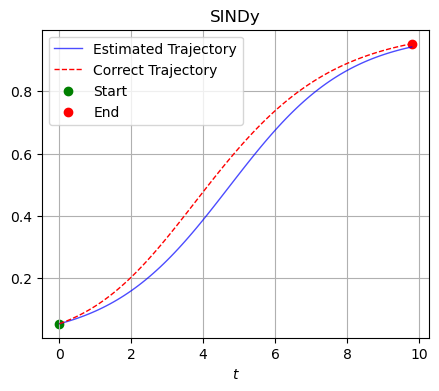

In [37]:
# evaluation:
n_sample = 25
rmse_b, _ = SINDy_data.evaluate_RMSE(model_b, ode, freq, n_sample, [0.1, 1.5], [0., 0.2], dim_k)
print('Best Model RMSE: ', rmse_b)
n_sample = 1
title = 'SINDy'
SINDy_data.evaluate_traj(model_b, ode, freq, n_sample, [0.05, 0.5], [0.05, 0.5], dim_x, dim_k, title=title, T_aux=10)

Best Model 1 RMSE:  0.14889452001074738


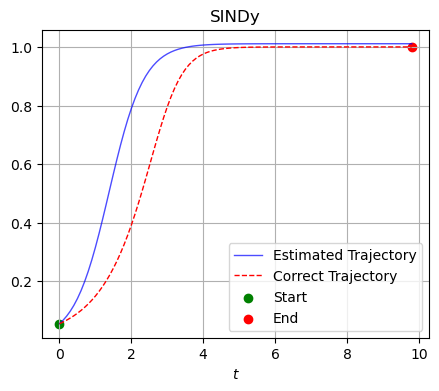

In [39]:
# overfitting issues:
init_point = [0.05, 2.5]
n_sample = 2
rmse, _ = SINDy_data.evaluate_RMSE(model_b, ode, freq, n_sample, init_point, init_point, dim_k)
print('Best Model 1 RMSE: ', rmse)
n_sample = 1
title = 'SINDy'
SINDy_data.evaluate_traj(model_b, ode, freq, n_sample, init_point, init_point, dim_x, dim_k, title=title)